<a href="https://colab.research.google.com/github/AndAmir/Covid19-model-colab/blob/master/Covid19_precondition_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#!pip install tensorflow-gpu
#!pip install mlxtend==0.17.0

In [ ]:
import tensorflow as tf
import pandas as pd
import datetime as dt
import numpy as np

from tensorflow import feature_column
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

#Eleminating NaN/Unknown Values
###Currently replaceing these values(with for example the median value) is not needed due to having such a large dataset, and doing so can sqew results.

In [ ]:
'''
This code was put into one cell to improve readability and focus to more important cells
df = pd.read_csv("/content/covid.csv")
df = df[df.icu != 97.0]
df.insert(6,"symptomEntry_Delta",0)

df.reset_index(drop=True)
for a, b, i in zip(df.date_symptoms, df.entry_date,range(121913#size of dataset Should have used df.size)):
  a = dt.date(2020, int(b[3:5]),int(b[:2])) - dt.date(2020, int(a[3:5]),int(a[:2]))
  df.iloc[i,df.columns.get_loc('symptomEntry_Delta')] = a.days
df.pop('id')

df['icu'].value_counts()
df = df[df.icu != 99.0]
df.reset_index(drop=True)
df.to_csv('covid_edited.csv')

df = pd.read_csv('/content/covid_edited.csv')
df.drop(columns=['date_symptoms', 'entry_date','date_died','patient_type','contact_other_covid'], inplace= True)

df.drop(df.loc[df['diabetes']==98].index, inplace=True)
df.drop(df.loc[df['inmsupr']==98].index, inplace=True)
df.drop(df.loc[df['asthma']==98].index, inplace=True)
df.drop(df.loc[df['copd']==98].index, inplace=True)
df.drop(df.loc[df['hypertension']==98].index, inplace=True)
df.drop(df.loc[df['other_disease']==98].index, inplace=True)
df.drop(df.loc[df['obesity']==98].index, inplace=True)
df.drop(df.loc[df['renal_chronic']==98].index, inplace=True)
df.drop(df.loc[df['tobacco']==98].index, inplace=True)
df.drop(df.loc[df['cardiovascular']==98].index, inplace=True)

df.drop(df.columns[df.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)
df = df.reset_index(drop=True)
df.to_csv('covid_modelReady.csv')
'''

In [ ]:
df = pd.read_csv('/content/covid_modelReady.csv')
df.drop(df.columns[df.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)

#Columns of Interest


In [ ]:
feature_columns = []

# numeric cols
for header in ['sex', 'symptomEntry_Delta', 'intubed','pneumonia','age','diabetes','copd','asthma','imsupr','hypertension','other_disease','cardiovascular','renal_chronic','tobacco']:
  feature_columns.append(feature_column.numeric_column(header))

#Bucketized Columns: 
age, symptomEntry_Delta 

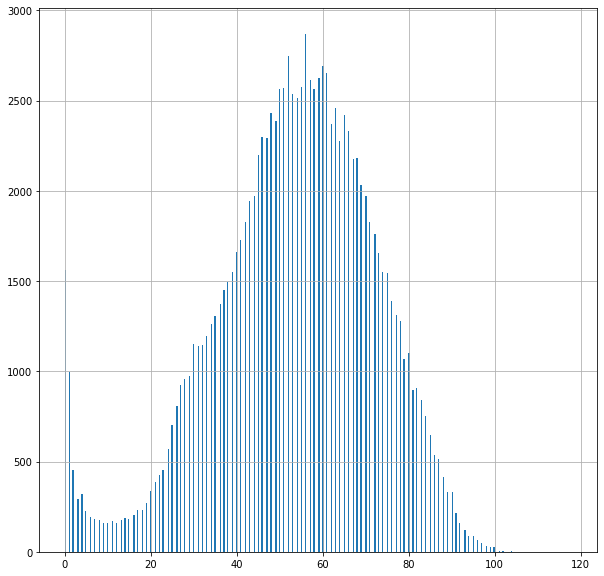

In [ ]:
df['age'].hist(bins=400,figsize=(10,10))

In [ ]:
age = feature_column.numeric_column('age')
age_buckets = feature_column.bucketized_column(age, boundaries=[0,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,90,100,120])
feature_columns.append(age_buckets)

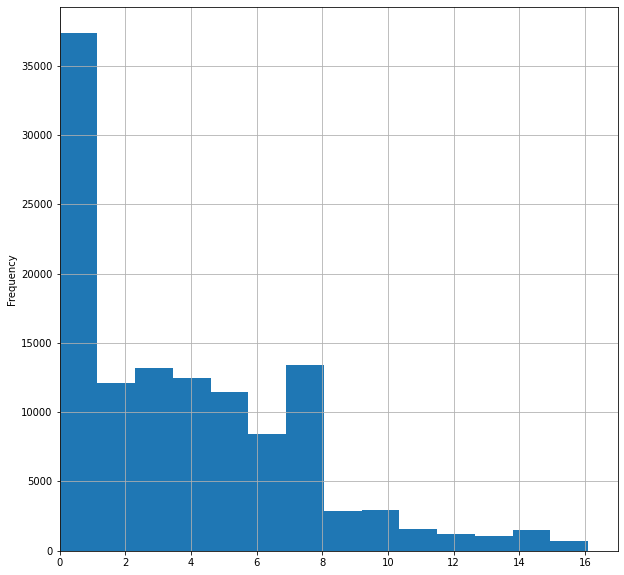

In [ ]:
df['symptomEntry_Delta'].plot.hist(bins=100,figsize=(10,10),xlim=(0,17),grid=True)

In [ ]:
symptomEntryD = feature_column.numeric_column('symptomEntry_Delta')
symptomEntryD_buckets = feature_column.bucketized_column(symptomEntryD, boundaries=[0,1,4,7,9,12,17])
feature_columns.append(symptomEntryD_buckets)

#One-hot encoding Columns: 
intubed,	pneumonia, diabetes,	copd,	asthma,	inmsupr,	hypertension,	other_disease,	cardiovascular,	obesity,	renal_chronic,	tobacco


In [ ]:
oneHotColumns = ['intubed', 'pneumonia', 'diabetes', 'copd', 'asthma', 'inmsupr', 'hypertension', 'other_disease', 'cardiovascular', 'obesity', 'renal_chronic', 'tobacco']

In [ ]:
for col_name in oneHotColumns: 
  categorical_column = feature_column.categorical_column_with_vocabulary_list(col_name, df[col_name].unique())
  indicator_column = feature_column.indicator_column(categorical_column)
  feature_columns.append(indicator_column)

In [ ]:
# A utility method to create a tf.data dataset from a Pandas Dataframe
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
  dataframe = dataframe.copy()
  labels = dataframe.pop('icu')
  ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  return ds

In [ ]:
train, test = train_test_split(df, test_size=0.2)
train, val = train_test_split(train, test_size=0.2)

In [ ]:
batch_size = 32
train_ds = df_to_dataset(train, batch_size=batch_size)
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size)

In [ ]:
feature_layer = tf.keras.layers.DenseFeatures(feature_columns)

In [ ]:
df['icu'].value_counts()

2    110340
1      9842
Name: icu, dtype: int64

In [ ]:
model = tf.keras.Sequential([
  feature_layer,
  layers.Dense(128, activation='relu'),
  layers.Dense(128, activation='relu'),
  layers.Dropout(.1),
  layers.Dense(1)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.fit(train_ds,
          validation_data=val_ds,
          epochs=10)

Epoch 1/10
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
2397/2404 [============================>.] - ETA: 0s - loss: -2232006.0000 - accuracy: 0.0824WARNING:tensorflow:Layers in a Sequential model should only have a single input tensor, but we receive a <class 'dict'> input: {'sex': <tf.Tensor 'ExpandDims_14:0' shape=(None, 1) dtype=int64>, 'symptomEntry_Delta': <tf.Tensor 'ExpandDims_15:0' shape=(None, 1) dtype=int64>, 'intubed': <tf.Tensor 'ExpandDims_8:0' shape=(None, 1) dtype=int64>, 'pneumonia': <tf.Tensor 'ExpandDims_11:0' shape=(None, 1) dtype=int64>, 'age': <tf.Tensor 'ExpandDims:0' shape=(None, 1) dtype=int64>, 'pregnancy': <tf.Tensor 'ExpandDims_12:0' shape=(None, 1) dtype=int64>, 'diabetes': <tf.Tensor 'ExpandDims_5:0' shape=(None, 1) dtype=int64>, 'copd': <tf.Tensor 'ExpandDims_3:0' shape=(None, 1) dtype=int64>, 'asthma': <tf.Tensor 'ExpandDims_1:0' shape=(None, 1) dtype=int64>, 'inmsupr': <tf.Tensor 'ExpandDi